In [6]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install opencv-python

     ---------------------------------------- 1.8/1.8 MB 2.0 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

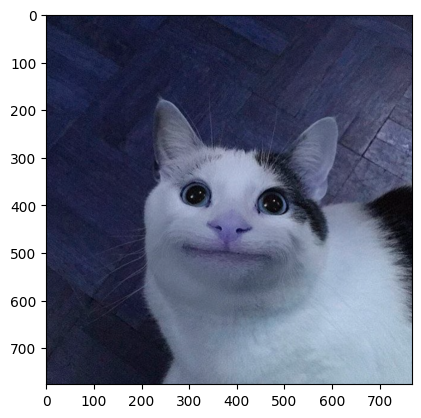

In [11]:
image = cv2.imread('./image.png')
plt.imshow(image);

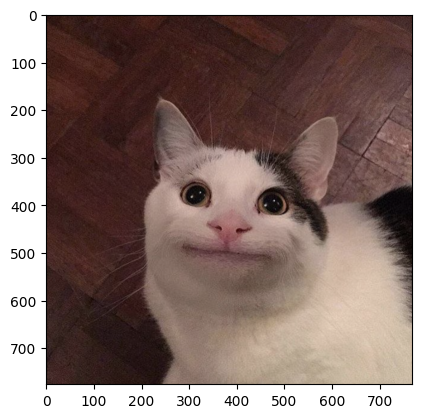

In [12]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

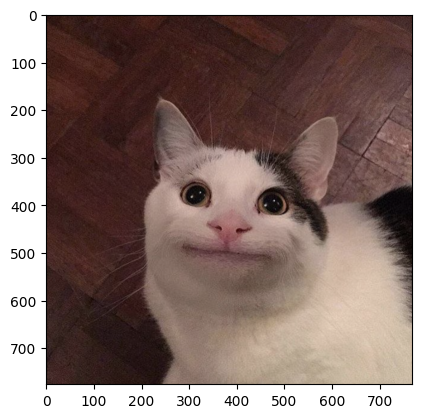

In [13]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

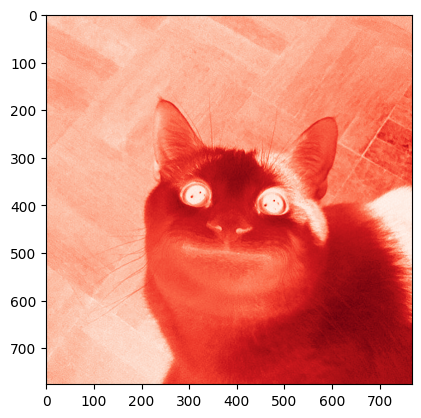

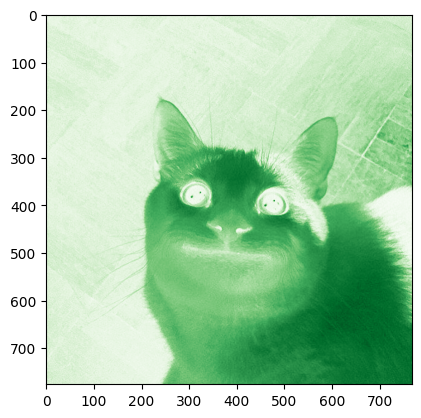

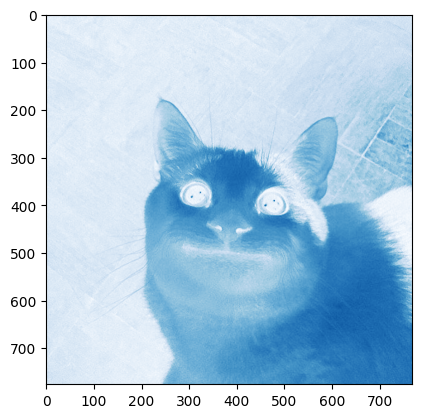

In [14]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


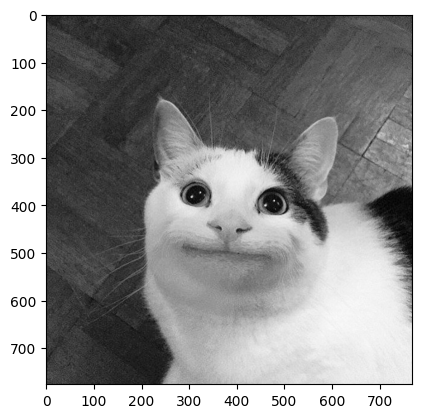

In [16]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [7]:
# !pip3 install scipy

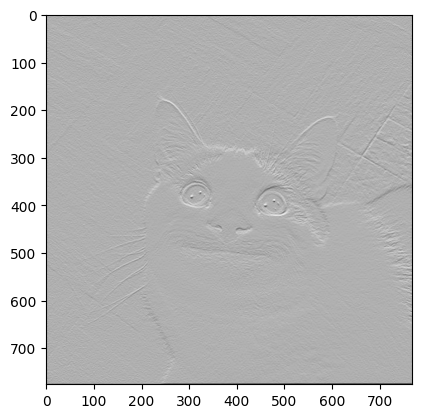

In [17]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

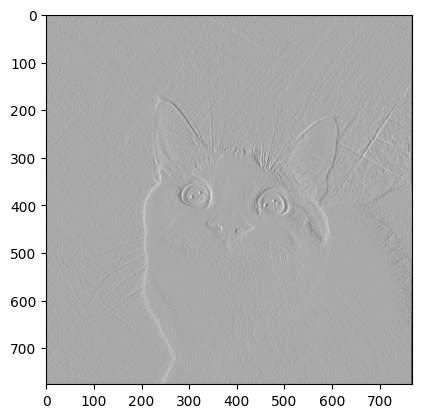

In [18]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

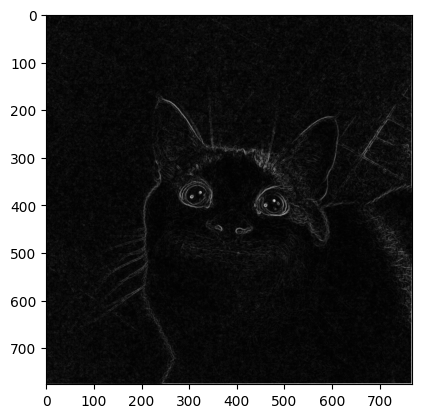

In [19]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [20]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [21]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [22]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [14]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [23]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [24]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [26]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [27]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:07<00:00, 1.37MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 647kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.59MB/s]


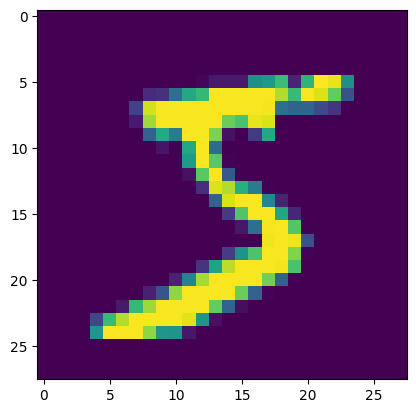

In [28]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [29]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [30]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [31]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:02<00:00, 61.44it/s]


Epoch: 0, loss: 0.3202982246875763, accuracy: 0.9098


100%|██████████| 157/157 [00:02<00:00, 71.99it/s]


Epoch: 2, loss: 0.23290111124515533, accuracy: 0.9315


100%|██████████| 157/157 [00:02<00:00, 64.15it/s]

Epoch: 4, loss: 0.18695269525051117, accuracy: 0.946


In [23]:
0.9462

0.9462

In [32]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [33]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 59.78it/s]


Epoch: 0, loss: 0.26598459482192993, accuracy: 0.925


100%|██████████| 157/157 [00:02<00:00, 63.58it/s]


Epoch: 2, loss: 0.12676939368247986, accuracy: 0.9626


100%|██████████| 157/157 [00:02<00:00, 52.80it/s]

Epoch: 4, loss: 0.08610885590314865, accuracy: 0.9746


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

## Решение

Добавила в train логгирование, сбор данных для построения графиков loss и accuracy и возможность изменения функции ошибки.

In [ ]:
def train(model, optimizer, criterion=F.cross_entropy, n_epochs=5, val_every=1):
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_dataloader))

        # валидация
        model.eval()
        val_loss = 0
        correct = 0

        if epoch % val_every == 0:
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = criterion(y_pred, y_val)
                    val_loss += loss.item()
                    correct += (torch.argmax(y_pred, dim=1) == y_val).sum().item()

            val_losses.append(val_loss / len(val_dataloader))
            val_acc = correct / len(val_dataloader.dataset)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1}/{n_epochs} | "
                f"Train loss: {train_losses[-1]:.4f} | "
                f"Val loss: {val_losses[-1]:.4f} | "
                f"Val acc: {val_acc:.4f}")
                
    return train_losses, val_losses, val_accuracies

В сеть я добавила больше слоёв, больше фильтров, уменьшила сжатие в MaxPool2d (4 при 28 за раз мне показалось многовато), уменьшила размер ядра для получения большей информации и улучшения текущего байзлайна. Оптимизатор взяла Adam как универсальный и часто используемый.

In [40]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 2 раза по каждой из сторон
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
train_losses, val_losses, val_accuracies = train(model, optimizer, n_epochs=3)

100%|██████████| 157/157 [00:03<00:00, 44.29it/s]


Epoch 1/3 | Train loss: 0.1334 | Val loss: 0.0458 | Val acc: 0.9853


100%|██████████| 157/157 [00:03<00:00, 47.25it/s]


Epoch 2/3 | Train loss: 0.0427 | Val loss: 0.0387 | Val acc: 0.9880


100%|██████████| 157/157 [00:03<00:00, 43.62it/s]

Epoch 3/3 | Train loss: 0.0289 | Val loss: 0.0253 | Val acc: 0.9927


Да, работало дольше, но результат того стоил:) Удалось даже сократить количество эпох.

In [42]:
# постройка графиков
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Val Loss')
    plt.legend()

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

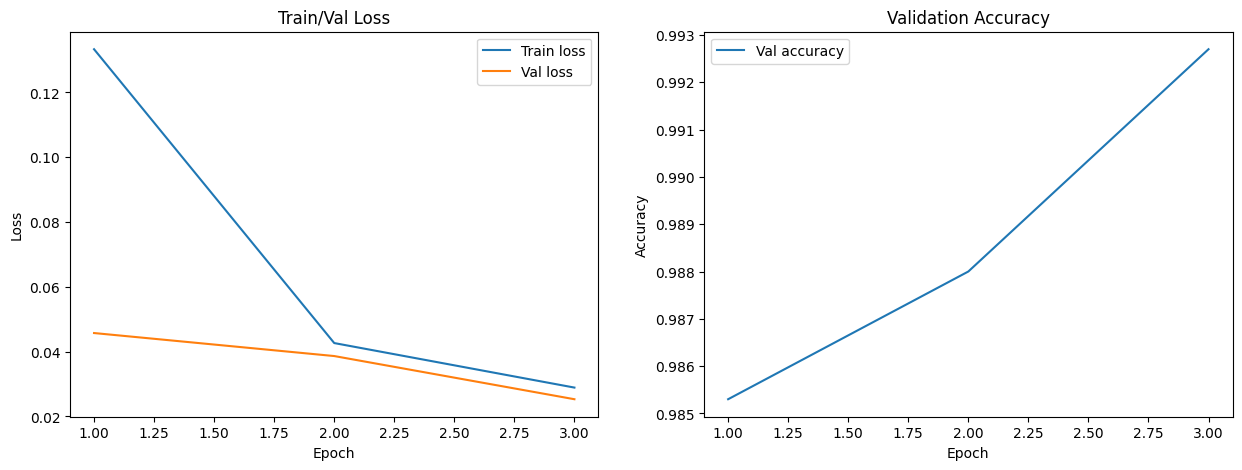

In [43]:
plot_metrics(train_losses, val_losses, val_accuracies)

Попробовала взять функцию ошибки NLLLoss, но она ожиидает логарифмы вероятностей, а потому пришлось добавить в сеть в конце LogSoftmax:

(назовём этот запуск "Версия 1")

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # вход (1, 28, 28), выход (32, 28, 28)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 2 раза по каждой из сторон:  вход (32, 28, 28), выход (32, 14, 14)
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # вход (32, 14, 14), выход (64, 14, 14)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # вход (64, 14, 14), выход (64, 7, 7)
    nn.Flatten(),
    nn.Linear(7*7*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
train_losses_1, val_losses_1, val_accuracies_1 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=5)

100%|██████████| 157/157 [00:02<00:00, 54.14it/s]


Epoch 1/5 | Train loss: 0.0121 | Val loss: 0.0289 | Val acc: 0.9913


100%|██████████| 157/157 [00:03<00:00, 51.19it/s]


Epoch 2/5 | Train loss: 0.0099 | Val loss: 0.0335 | Val acc: 0.9910


100%|██████████| 157/157 [00:03<00:00, 50.59it/s]


Epoch 3/5 | Train loss: 0.0087 | Val loss: 0.0330 | Val acc: 0.9922


100%|██████████| 157/157 [00:03<00:00, 43.15it/s]


Epoch 4/5 | Train loss: 0.0085 | Val loss: 0.0361 | Val acc: 0.9903


100%|██████████| 157/157 [00:03<00:00, 51.06it/s]

Epoch 5/5 | Train loss: 0.0066 | Val loss: 0.0319 | Val acc: 0.9915


Можно заметить, что на 4 эпохе модель начала переобучаться, а потому снизим число эпох до 3.

In [49]:
train_losses_1, val_losses_1, val_accuracies_1 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=3)

100%|██████████| 157/157 [00:03<00:00, 43.78it/s]


Epoch 1/3 | Train loss: 0.0045 | Val loss: 0.0314 | Val acc: 0.9919


100%|██████████| 157/157 [00:02<00:00, 57.52it/s]


Epoch 2/3 | Train loss: 0.0051 | Val loss: 0.0409 | Val acc: 0.9905


100%|██████████| 157/157 [00:09<00:00, 16.25it/s]

Epoch 3/3 | Train loss: 0.0042 | Val loss: 0.0352 | Val acc: 0.9922


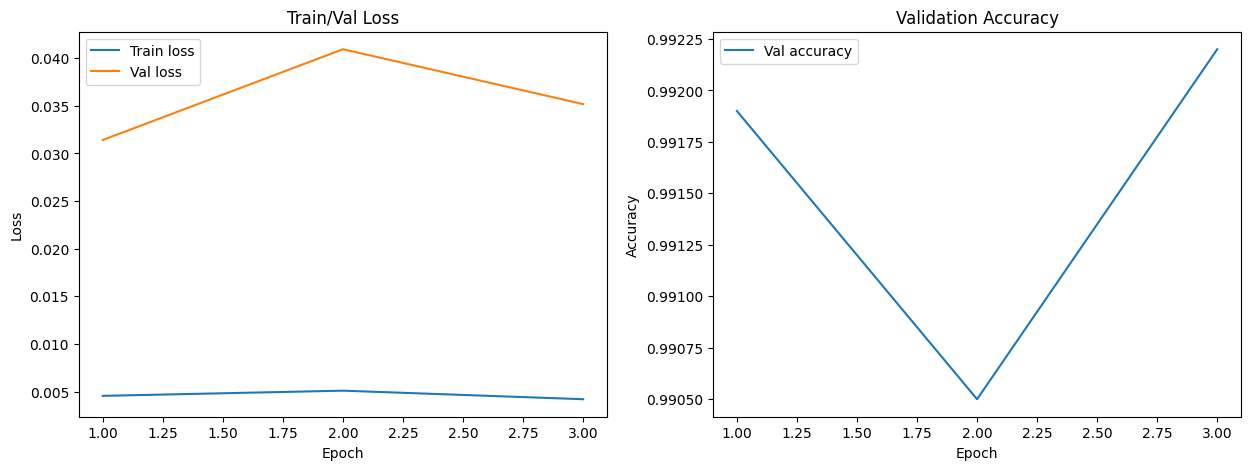

In [50]:
plot_metrics(train_losses_1, val_losses_1, val_accuracies_1)

Попробовала упростить модель для увеличения скорости работы без сильной потери в качестве

Формула для выхода свёртки

$H_{out}​=(H_{in}​+2*padding−kernel~size)/stride​+1$

(назовём этот запуск "Версия 2")

In [55]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),  # grayscale (1, 28, 28) -> (28, 26, 26)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон (28, 26, 26) -> (28, 6, 6)
    nn.Flatten(),
    nn.Linear(6*6*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [56]:
train_losses_2, val_losses_2, val_accuracies_2 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=5)

100%|██████████| 157/157 [00:02<00:00, 59.36it/s]


Epoch 1/5 | Train loss: 0.1542 | Val loss: 0.0654 | Val acc: 0.9785


100%|██████████| 157/157 [00:02<00:00, 74.16it/s]


Epoch 2/5 | Train loss: 0.0676 | Val loss: 0.0737 | Val acc: 0.9762


100%|██████████| 157/157 [00:02<00:00, 57.58it/s]


Epoch 3/5 | Train loss: 0.0543 | Val loss: 0.0557 | Val acc: 0.9834


100%|██████████| 157/157 [00:02<00:00, 58.97it/s]


Epoch 4/5 | Train loss: 0.0508 | Val loss: 0.0586 | Val acc: 0.9825


100%|██████████| 157/157 [00:02<00:00, 65.81it/s]

Epoch 5/5 | Train loss: 0.0519 | Val loss: 0.0661 | Val acc: 0.9828


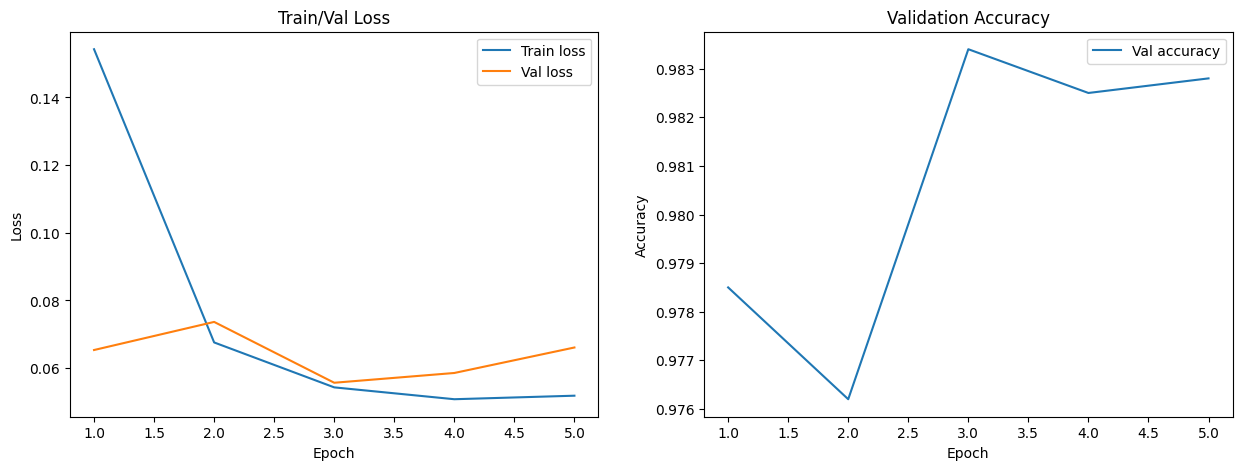

In [57]:
plot_metrics(train_losses_2, val_losses_2, val_accuracies_2)

(назовём этот запуск "Версия 3")

In [59]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, padding=1),  # grayscale (1, 28, 28) -> (20, 28, 28)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 2 раза по каждой из сторон (20, 28, 28) -> (20, 14, 14)
    nn.Flatten(),
    nn.Linear(14*14*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [60]:
train_losses_3, val_losses_3, val_accuracies_3 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=5)

100%|██████████| 157/157 [00:02<00:00, 69.46it/s]


Epoch 1/5 | Train loss: 0.2048 | Val loss: 0.0837 | Val acc: 0.9730


100%|██████████| 157/157 [00:02<00:00, 72.32it/s]


Epoch 2/5 | Train loss: 0.0711 | Val loss: 0.0773 | Val acc: 0.9768


100%|██████████| 157/157 [00:02<00:00, 63.47it/s]


Epoch 3/5 | Train loss: 0.0525 | Val loss: 0.0854 | Val acc: 0.9772


100%|██████████| 157/157 [00:02<00:00, 78.08it/s]


Epoch 4/5 | Train loss: 0.0488 | Val loss: 0.0701 | Val acc: 0.9802


100%|██████████| 157/157 [00:02<00:00, 72.66it/s]

Epoch 5/5 | Train loss: 0.0419 | Val loss: 0.0820 | Val acc: 0.9803


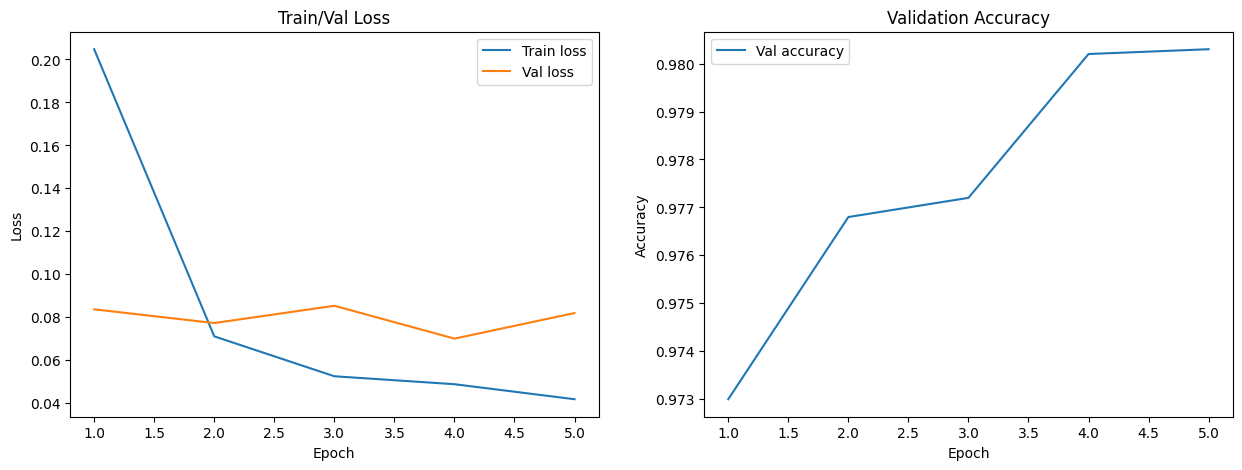

In [61]:
plot_metrics(train_losses_3, val_losses_3, val_accuracies_3)

(назовём этот запуск "Версия 4")

In [67]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=25, kernel_size=5, padding=2),  # grayscale (1, 28, 28) -> (25, 28, 28)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон (25, 28, 28) -> (25, 7, 7)
    nn.Flatten(),
    nn.Linear(7*7*25, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [68]:
train_losses_4, val_losses_4, val_accuracies_4 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=5)

100%|██████████| 157/157 [00:02<00:00, 60.93it/s]


Epoch 1/5 | Train loss: 0.1725 | Val loss: 0.0600 | Val acc: 0.9813


100%|██████████| 157/157 [00:02<00:00, 77.70it/s]


Epoch 2/5 | Train loss: 0.0763 | Val loss: 0.0587 | Val acc: 0.9829


100%|██████████| 157/157 [00:02<00:00, 70.22it/s]


Epoch 3/5 | Train loss: 0.0662 | Val loss: 0.0837 | Val acc: 0.9750


100%|██████████| 157/157 [00:08<00:00, 18.45it/s]


Epoch 4/5 | Train loss: 0.0648 | Val loss: 0.0809 | Val acc: 0.9779


100%|██████████| 157/157 [00:08<00:00, 19.27it/s]

Epoch 5/5 | Train loss: 0.0607 | Val loss: 0.0756 | Val acc: 0.9816


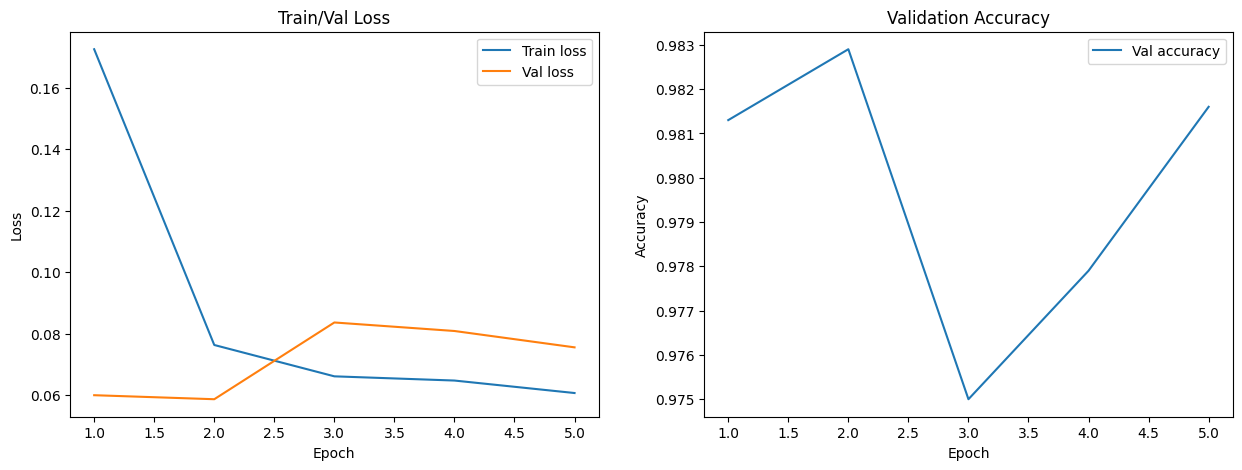

In [69]:
plot_metrics(train_losses_4, val_losses_4, val_accuracies_4)

(назовём этот запуск "Версия 5")

In [70]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=30, kernel_size=4, padding=1, stride=2),  # grayscale (1, 28, 28) -> (30, 14, 14)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   # сократим изображение в 2 раза по каждой из сторон (30, 14, 14) -> (30, 7, 7)
    nn.Flatten(),
    nn.Linear(7*7*30, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [71]:
train_losses_5, val_losses_5, val_accuracies_5 = train(model, optimizer, criterion=nn.NLLLoss(), n_epochs=5)

100%|██████████| 157/157 [00:02<00:00, 73.64it/s]


Epoch 1/5 | Train loss: 0.1750 | Val loss: 0.0861 | Val acc: 0.9722


100%|██████████| 157/157 [00:04<00:00, 33.45it/s]


Epoch 2/5 | Train loss: 0.0792 | Val loss: 0.0699 | Val acc: 0.9778


100%|██████████| 157/157 [00:02<00:00, 68.25it/s]


Epoch 3/5 | Train loss: 0.0701 | Val loss: 0.0848 | Val acc: 0.9770


100%|██████████| 157/157 [00:01<00:00, 81.35it/s]


Epoch 4/5 | Train loss: 0.0655 | Val loss: 0.1077 | Val acc: 0.9724


100%|██████████| 157/157 [00:02<00:00, 68.29it/s]

Epoch 5/5 | Train loss: 0.0602 | Val loss: 0.1224 | Val acc: 0.9739


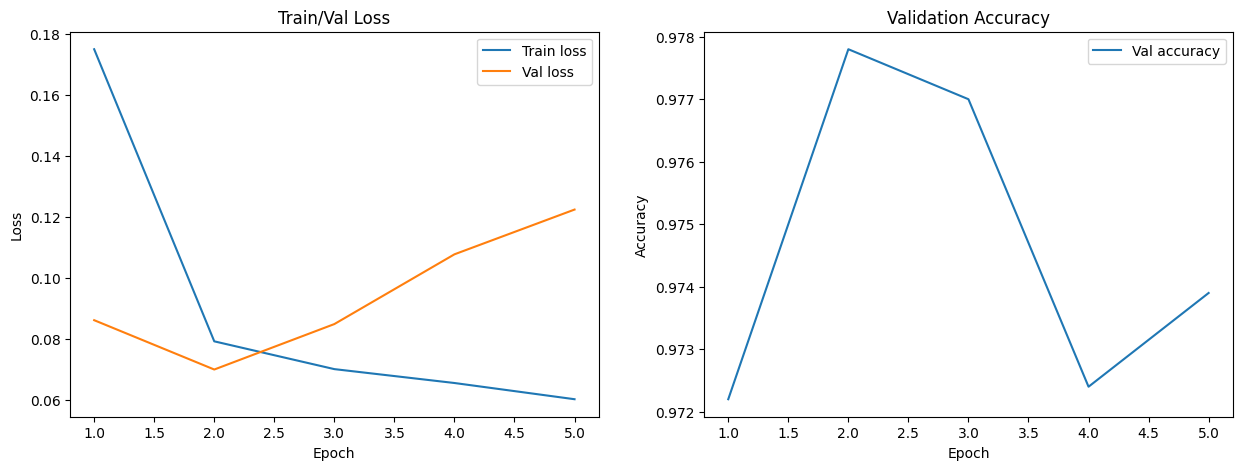

In [72]:
plot_metrics(train_losses_5, val_losses_5, val_accuracies_5)

Итого сравним все 4 (так как первый запуск был на трёх эпохах и сеть сильно отличалась) версии на 3 совместных графиках:

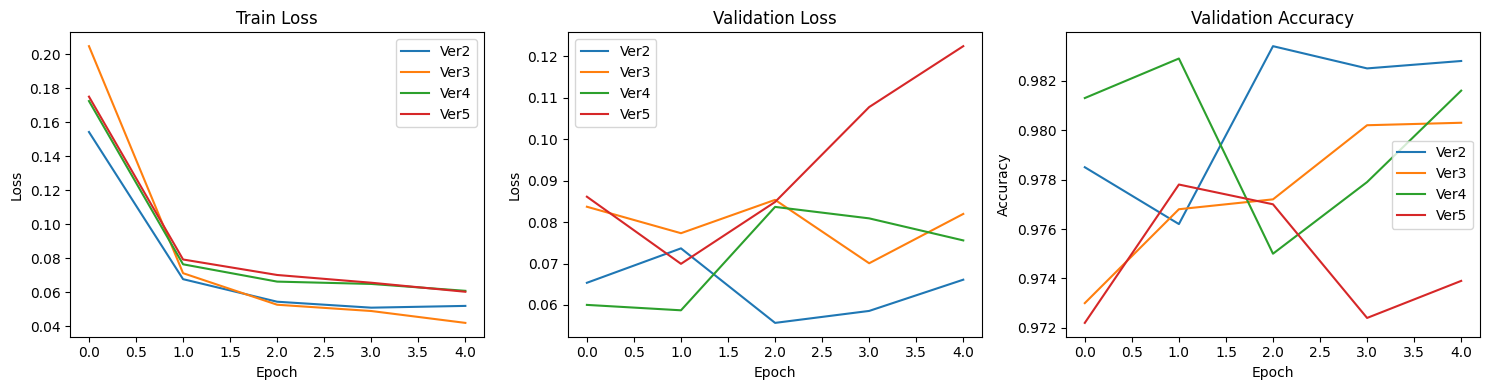

In [74]:
import matplotlib.pyplot as plt

# Список моделей для удобства
experiments = {
    "Ver2": (train_losses_2, val_losses_2, val_accuracies_2),
    "Ver3": (train_losses_3, val_losses_3, val_accuracies_3),
    "Ver4": (train_losses_4, val_losses_4, val_accuracies_4),
    "Ver5": (train_losses_5, val_losses_5, val_accuracies_5),
}

# === 1. Train Loss ===
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
for name, (train_losses, _, _) in experiments.items():
    plt.plot(train_losses, label=name)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# === 2. Validation Loss ===
plt.subplot(1, 3, 2)
for name, (_, val_losses, _) in experiments.items():
    plt.plot(val_losses, label=name)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# === 3. Validation Accuracy ===
plt.subplot(1, 3, 3)
for name, (_, _, val_acc) in experiments.items():
    plt.plot(val_acc, label=name)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Выводы: Лучше всего себя показала вторая версия, а пятая явно переобучилась. Тем не менее даже на 5 эпохах вторая версия не достигла точности первой (0,9922 > 0,9828). И тут встаёт извечный выбор между скоростью и качеством работы, хотя время на 3 эпохах версии 1 примерно равно времени работы на 5 эпохах версии 2.

Подсчёт числа параметров

In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(model))

Trainable parameters: 190088
